# Is humanity's gluttony killing the planet?

With rising life expectancies and a rapid increase in population across the globe, it is getting harder for humanity to sustain its nutritional needs. The inefficient upscale of food production is having a noticeable negative impact on the planet. Deforestation, increased livestock farming, and the excessive use of fertilisers, which are all related to food production, are the main causal factors behind rising emissions in greenhouse gasses and consequently, global warming. In an effort to further the advancements in battling climate change, we aim to reveal how food production and its necessary resources have evolved, and the relation to global warming. We will do so by carrying out an analysis of the data published by the Food and Agriculture Organization of the United Nations (FAOSTAT). We believe that by doing so, we could potentially increase general public awareness of this topic and compel people to keep the stated issue in mind when acting as consumers.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image
from IPython.core.display import SVG
import matplotlib.pyplot as plt
import folium
from matplotlib.ticker import MaxNLocator

/home/tim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


- How has the world recenlty evolved in terms of factors that are relevant to agriculture and climate change (agricultural activity, CO2 emissions, deforestation, etc.) ? 
- What are the most popular food types (per country and overall) and their relative impact on CO2 emissions ?
- What countries are the most/least efficient in terms of meeting their nutritional needs ?
- How do countries collaborate in order to meet these needs ?
- Are there any trends in the production of different food types ?
- What realizable good practices exist in order to reduce the negative impacts of food production ?

## l. How has the world recenlty evolved in terms of factors that are relevant to agriculture and climate change?

As an introductory section to this topic, we will explore how various factors that are related to climate change have evolved in recent years and how humanity's agricultural activity contributes to these. Specifically, we look at:
- Population levels
- Temperature evolution
- Greenhouse gas emissions
- Evolution of forest areas

### Population

First of all, we load the [population dataset](http://www.fao.org/faostat/en/#data/OA) which illustrates the population levels for countries, continents, groups of countries, and the world over time for various population groups (e.g. Males, Females, Both sexes). We particularly look at the evolution of total world population over time and the proportion of world population that is represented by [Low Income Food Deficit Countries (LIFDCs)](http://www.fao.org/countryprofiles/lifdc/en/). LIDFCs are countries that have a per capita Gross National Income (GNI) below a predefined threhsold and that are net food importers in terms of calories. These are of particular interest as these countries are dependent on other countries' food production and thus increases these driving up other nation's CO2 emissions. Additionally, these countries would cause an increase in general flow of food products between countries which drives up emissions caused by transportation.

In [2]:
# Load population data
population_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')

In [3]:
# Create dataframe with world level population keeping relevant columns
world_population = population_df[population_df.Area=='World'][['Area', 'Year', 'Element', 'Unit', 'Value']]

# Create dataframe with low income food deficit countries population levels
food_deficit_population = population_df[population_df.Area=='Low Income Food Deficit Countries']\
[['Year', 'Element', 'Value']]

In [4]:
# Rename columns
food_deficit_population = food_deficit_population.rename(columns={'Value': 'num_people_def_countries'})

In [5]:
# Join world population dataset with low income food deficit countries population dataset on Year
world_population = pd.merge(world_population, food_deficit_population, on=['Year', 'Element'], how='inner')

In [6]:
# Compute the proportion of low income food deficit countries' populations of world population for each year
world_population['ratio_def_pop'] = world_population.num_people_def_countries/world_population.Value

In [7]:
# Limit dataset timeline up to 2017 to exclude predictive data
world_population = world_population[(world_population.Year<2018) 
                                    & (world_population.Element=='Total Population - Both sexes')]

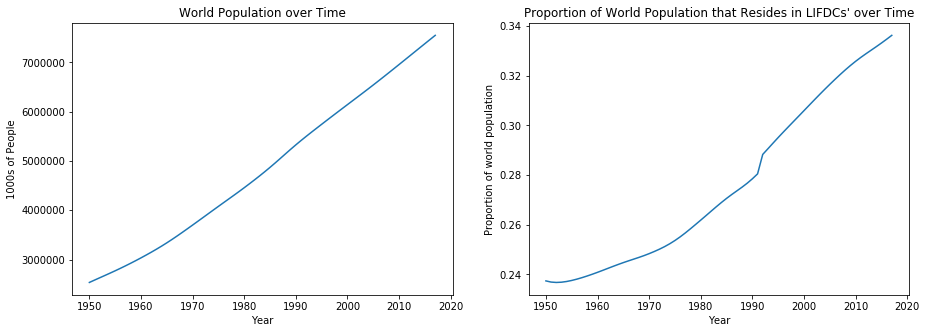

In [8]:
# Plot evolution of world population and proportion of both aforementioned sub groups over time
fig = plt.figure(figsize=(15,5))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.plot(world_population.Year.values, world_population.Value.values)
p1.set_title('World Population over Time')
p1.set_xlabel('Year')
p1.set_ylabel('1000s of People')
p2.plot(world_population.Year.values, world_population.ratio_def_pop.values)#, label='Low Income Food Deficit Countries')
p2.set_title("Proportion of World Population that Resides in LIFDCs' over Time")
p2.set_xlabel('Year')
p2.set_ylabel('Proportion of world population')
plt.show()

We can clearly observe that the overall population level of the planet has significantly increased over the past 60 years (going roughly from 2.5 to 7.5 billion). Alongside this, we notice that the proportion of the total population that reside in countries that are LIDFCs is also on the rise. This highlights the fact that there is a greater number of humans that rely on limited food production resources. Both, world and LDIFC population growths are striking and signal upcoming challenges in the ability to sustain these in an efficient manner in terms of green house gas emissions.

While processing the data above, we noticed that different levels of aggregation (countries, continents, etc.) are represented as separate rows. In order to obtain the mapping between continents and countries, which will be useful throughout our analysis, we downloaded this information from the FAOSTAT website (as it was not available in the original datasets) and integrated it with the populations data.

In [9]:
# Load country metadata mapping country groups to countries
country_metadata = pd.read_csv('data/FAOSTAT_data_11-19-2019.csv')

In [10]:
# Extract list of countries and continents from the above dataset
countries = country_metadata.Country.drop_duplicates().values
continents = country_metadata[(country_metadata['Country Group Code']>5000) & (country_metadata['Country Group Code']%100==0)]
continents = continents['Country Group'].drop_duplicates().values

### Evolution of temperature levels

Secondly, we investigate how the temperature levels have evolved in recent years. We visualise the evolution of the world's yearly temperature anomlies. Temperature anomalies, as defined in [FAOSTAT documentation](http://fenixservices.fao.org/faostat/static/documents/ET/ET_e.pdf), indicate how much warmer or colder it is than normal for a particular place and time. Normal always means the average over the 30-year period 1951-1980 for that place and time of year. 

In [11]:
# Load temperatures dataset
temperatures_df = pd.read_csv('data/Environment_Temperature_change_E_All_Data_(Normalized).zip', encoding='latin-1')

In [12]:
# Create dataframe retaining information pertaining to the world, yearly averages and temperature changes
world_temperatures_changes = temperatures_df[(temperatures_df.Area=='World') 
                                             & (temperatures_df.Months=='Meteorological year') 
                                             & (temperatures_df.Element=='Temperature change') ]

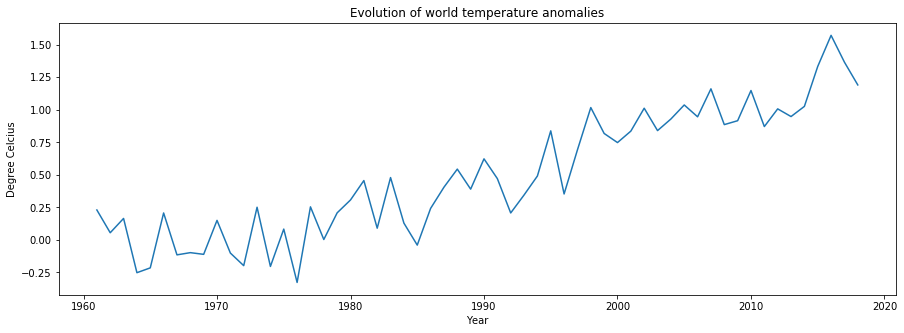

In [13]:
# Plot the evolution of world temperature anomalies
plt.figure(figsize=(15,5))
plt.plot(world_temperatures_changes.Year.values, world_temperatures_changes.Value.values)
plt.title('Evolution of world temperature anomalies')
plt.xlabel('Year')
plt.ylabel('Degree Celcius')
plt.show()

From the above plot, the increasing trend in temperature is apparent even though we have only plotted data since 1960 (all that is available from FAOSTAT). If data prior to 1960 was made available, we would most likely have seen a longer ranging increasing trend since rising temperatures relate to greenhouse gas emissions which have started to increase since the industrial revolution. As rising temperature relate to greenhouse gas emissions, we investigate these below.

### Greenhouse Gas Emissions

Now we investigate the evolution of the CO2 equivalent emissions coming from Agriculture across the world. We also look at the contribution of these emissions to the total CO2 equivalent emissions. Greenhouse gas emissions in Agriculture consist of non-CO2 gases, namely methane (CH4) and nitrous oxide (N2O), associated with crop and livestock production and associated management activities. These are converted into CO2 equivalent emissions according to their global warming potential as outlined in [FAOSTAT documentation](http://fenixservices.fao.org/faostat/static/documents/GT/GT_e_2019.pdf).

In [14]:
# Load emissions by sector dataset
emissions_by_sector_df = pd.read_csv('data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip', 
                                  encoding='latin-1')

# Load agriculture emissions dataset
agriculture_emissions_df = pd.read_csv('data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip', 
                                       encoding='latin-1')

In [15]:
# Extract into a dataframe the latest data for different sectors' share in total global emissions
emissions_world_sectors = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                & (emissions_by_sector_df.Area=='World')
                                                & (emissions_by_sector_df.Year==emissions_by_sector_df.Year.max())]

The list of sectors below represents all the disjoint sectors that make up the total and was taken from [FAOSTAT official documentation](http://fenixservices.fao.org/faostat/static/documents/EM/EM_e.pdf)

In [16]:
sectors = ['Energy (energy, manufacturing and construction industries and fugitive emissions)', 'Transport', 
           'Residential, commercial, institutional and AFF', 'Industrial processes and product use', 'Waste', 
           'Other sources', 'International bunkers', 'Agriculture total', 'Land use sources']

In [17]:
# Filter emissions by sector dataframe to the above list of sectors
pie_df = emissions_world_sectors[emissions_world_sectors.Item.isin(sectors)]

In [18]:
# Extract into a dataframe the historic values of agriculture's share in total world emissions
world_ag_emissions_hist = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                 & (emissions_by_sector_df.Area=='World')
                                                 & (emissions_by_sector_df.Item=='Agriculture total')]

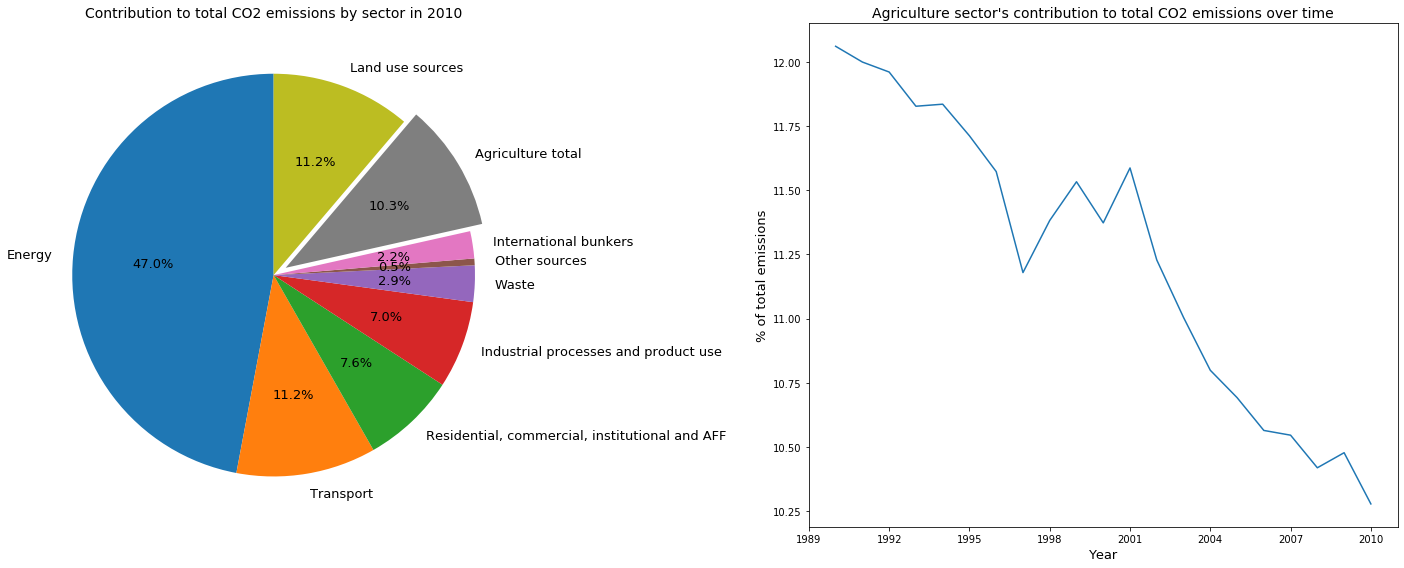

In [19]:
# Plot latest sector contributions to global emissions and the historic evolution of agriculture's share
fig = plt.figure(figsize=(20,8))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
sector_labels = sectors.copy()
sector_labels[0] = 'Energy'
p1.pie(pie_df.Value.values, explode=[0,0,0,0,0,0,0,0.07,0], labels=sector_labels, autopct='%1.1f%%', startangle=90, 
       textprops={'fontsize': 13})
p1.set_title('Contribution to total CO2 emissions by sector in ' + str(pie_df.Year.max()), fontsize=14)
p2.plot(world_ag_emissions_hist.Year.values, world_ag_emissions_hist.Value.values)
p2.set_xlabel('Year', fontsize=13)
p2.set_ylabel('% of total emissions', fontsize=13)
p2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2.set_title("Agriculture sector's contribution to total CO2 emissions over time", fontsize=14)
plt.tight_layout(w_pad=1)
plt.show()

From the pie plot above we can see that agriculture represents a sizeable proportion of total CO2 emissions (about 10%). It is worth noting that since agricultural products are imported and exported across the globe, Agriculture also impacts the emissions emanating from the Transport sector. Note that the biggest proportion of emissions comes from energy (energy, manufacturing and construction industries and fugitive emissions). Although we see that agriculture's share of emissions has decresead over the years (roughly from 12% to 10%), this could be potentially caused by the increase of another sector's share. We explore the evolution of the actual emissions from the agricultural sector below.

In [20]:
# Extract into a dataframe nominal values of agriculture CO2, CO2eq of CH4 and CO2eq of N2O emissions
world_agriculture_emissions = agriculture_emissions_df[(agriculture_emissions_df.Area=='World') 
                                                       & ~(agriculture_emissions_df.Element.isin(['Emissions (CH4)', 'Emissions (N2O)']))
                                                       & (agriculture_emissions_df.Item=='Agriculture total')
                                                       & (agriculture_emissions_df.Year<2018)]

In [21]:
# Extract list of years and gas types for plot below
xticks = world_agriculture_emissions.Year.drop_duplicates().sort_values().values
labels = world_agriculture_emissions.Element.drop_duplicates().values

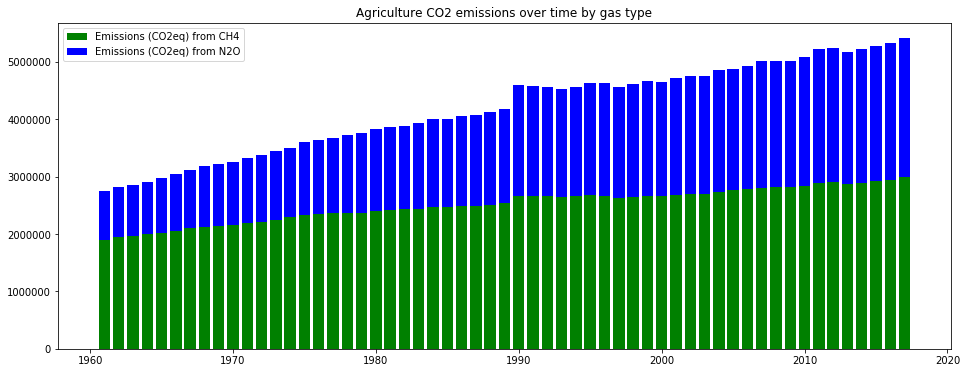

In [22]:
# Plot world's CO2eq emissions of agriculture sector over time split by CO2eq of CH4 and CO2eq of N2O
plt.figure(figsize=(16,6))
p1 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='g', label=labels[1])
p2 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[2]].Value.values, 
             bottom=world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='b', label=labels[2])
plt.title('Agriculture CO2 emissions over time by gas type')
plt.legend()
plt.show()

From the plot above we see that there is actually a steady increase in CO2 emissions emanating from the agricultural sector. This confirms the previously stated assumptions that although the agricultural sector's share of CO2 emissions has decreased, the actual value of emissions has increased. Additionally, we notice that in 1990 there is a slight abnormal jump in the level of CO2 emissions. Investigating the [FAOSTAT documentation](http://fenixservices.fao.org/faostat/static/documents/GT/GT_e_2019.pdf) related to this dataset, we learned that data for two types of emissions, namely 'Cultivation of organic soils' and 'Burning–savanna', start in 1990 which explains this jump. As such, to have a more illustrative view of the trend in CO2 emissions since 1960 we remove the emission data related to these two items from the dataset and replot.

In [23]:
# Compute total world CO2eq emissions from Cultivation of organic soils and Burning-savanna since 1990
new_emissions = ['Cultivation of Organic Soils', 'Burning - Savanna']
new_emissions_df = agriculture_emissions_df[(agriculture_emissions_df.Item.isin(new_emissions))
                                            & (agriculture_emissions_df.Area=='World')
                                            & (agriculture_emissions_df.Element=='Emissions (CO2eq)')]
new_emissions_df = new_emissions_df[['Year', 'Value']].groupby('Year').agg('sum')

Additionally, we also compute and plot the CO2eq emissions from Agriculture per capita over time. This would allow us to observe how increase in world population that we have observed earlier compares to the above increase in agricultural CO2eq emissions.

In [24]:
# Update previously computed world population dataframe to include population in number of people rather than in 1000s
population_hist = world_population[['Year', 'Value']].copy()
population_hist['Population'] = 1000 * population_hist.Value

In [25]:
# Join world agricultural emissions dataframe to population dataframe on year to have both on joint timeline
agriculture_co2_emissions = pd.merge(population_hist[['Year', 'Population']], 
                                     world_agriculture_emissions[world_agriculture_emissions.Element==labels[0]],
                                     on='Year')

agriculture_co2_emissions = agriculture_co2_emissions[['Year', 'Population', 'Area', 'Element', 'Unit', 'Value']]

In [26]:
# Join in data relating to new emissions starting in 1990 computed above
agriculture_co2_emissions = pd.merge(agriculture_co2_emissions, new_emissions_df, 
                                     on='Year', how='left', suffixes=('', '_new')).copy()

In [27]:
# For years prior to 1990 set new emissions value to 0
agriculture_co2_emissions.loc[agriculture_co2_emissions.Value_new.isnull(), 'Value_new'] = 0

# Compute total world agricultural CO2eq emissions for each year excluding the new emissions starting in 1990
agriculture_co2_emissions['Value'] = agriculture_co2_emissions.Value - agriculture_co2_emissions.Value_new

In [28]:
# Compute CO2eq emissions per capita
agriculture_co2_emissions['ag_co2_pc'] = agriculture_co2_emissions.Value / agriculture_co2_emissions.Population

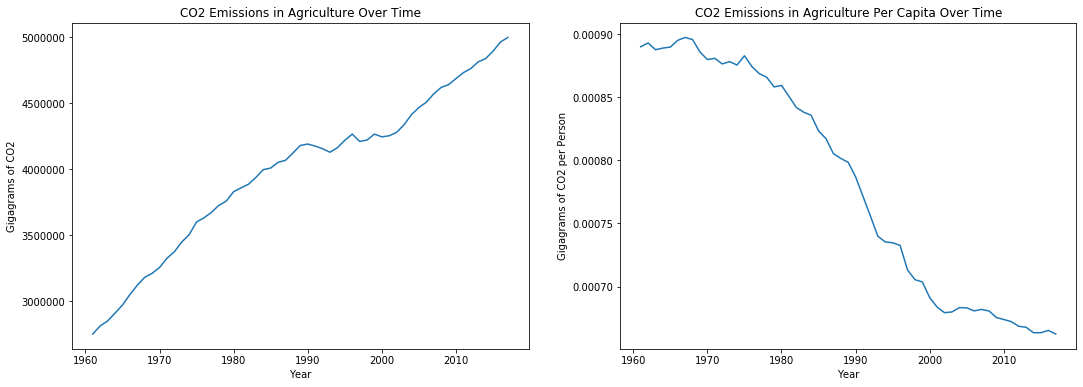

In [29]:
# Plot nominal and per capita CO2eq world agricultural emissions over time excluding new emissions
fig = plt.figure(figsize=(18,6))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.Value.values)
p2.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.ag_co2_pc.values)
p1.set_xlabel('Year')
p1.set_ylabel('Gigagrams of CO2')
p1.set_title('CO2 Emissions in Agriculture Over Time')
p2.set_xlabel('Year')
p2.set_ylabel('Gigagrams of CO2 per Person')
p2.set_title('CO2 Emissions in Agriculture Per Capita Over Time')
plt.show()

Having removed the effect of the additional emissions caused by 'Cultivation of organic soils' and 'Burning–savanna', we can now observe a smoother increase in agricultural CO2 emissions over time. Additionally, we also plot the number of gigagrams of agricultural CO2 emissions normalized by the world population as a function of time. We can observe that this curve decreases, as opposed to the one relating to the emissions of CO2. We have already observed that the world population has significantly increased over the same time period. This means that the increase in world population is greater than the increase in agricultural CO2 emissions. Since it is safe to assume that the vast majority of the world relies on agriculture for their nutritional needs, this could illustrate the fact that, in terms of efficiency of agricultural activity relative to CO2 emissions, the world has made progress over the last half century. This ties in well with the fact that the world has also made signifcant technological progress over the same time period. We investigate this further later on. Nonetheless, as our initial plot demonstrates, the CO2 levels are rising. A counter balancing factor to CO2 emissions are the carbon-absorbing properties of plants and trees. As such, we investigate the evolution of the world's forest areas below.

### Forest Area

As outlined above, plants and trees having carbon-absorbing properties. As a result, they represent a major factor in balancing the CO2 levels of the planet. Therefore, we investigate how the forest area of the planet and its ability to absorb carbon have evolved over time.

In [30]:
# Load the land area dataset
land_df = pd.read_csv('data/fao_data_land_data.zip', encoding='latin-1')

In [31]:
# Display the year of the most recent data point of interest
land_df[(land_df.country_or_area=='World +') & (land_df.category=='forest_area')].year.max()

2007.0

As the above land data only goes up to 2007, as opposed to the visualised datasets so far which go up to 2017, we decided to download the data from [FOASTAT](http://www.fao.org/faostat/en/#data/RL) instead.

In [32]:
# Load the newer version of the land area dataset
land_df = pd.read_csv('data/Inputs_LandUse_E_All_Data_(Normalized).zip', encoding='latin-1')

In [33]:
# Display the year of the most recent data point of interest
land_df[(land_df.Area=='World') & (land_df.Item=='Forest land')].Year.max()

2017

In [34]:
# Extract latest country area data for each country
land_per_country = land_df[(land_df.Area.isin(countries)) & (land_df.Element=='Area') 
                           & (land_df.Item=='Country area') & (land_df.Year==land_df.Year.max())]

# Extract latest forest area data for each country
forest_per_country = land_df[(land_df.Area.isin(countries)) & (land_df.Element=='Area') 
                             & (land_df.Item=='Forest land')]

# Extract latest carbon stock in living biomass data for each country
carbon_stock_per_country = land_df[(land_df.Area.isin(countries)) 
                                   & (land_df.Element=='Carbon stock in living biomass')]

In [35]:
# Add country codes for each country in order to plot map in Folium
country_to_code = country_metadata[['Country Code', 'ISO3 Code']].drop_duplicates().set_index('Country Code')
cspc_latest = pd.merge(carbon_stock_per_country, country_to_code, left_on='Area Code', right_index=True, how='left')

In [36]:
# We noticed that the country code of South Sudan did not correspond to the code expected by folium so we update it
cspc_latest.loc[cspc_latest['Area']=='South Sudan', 'ISO3 Code'] = 'SDS'

In [37]:
world_forest = land_df[(land_df.Item=='Forest land') & (land_df.Area=='World')]
world_forest_area = world_forest[world_forest.Element=='Area']
world_forest_cs = world_forest[world_forest.Element=='Carbon stock in living biomass']

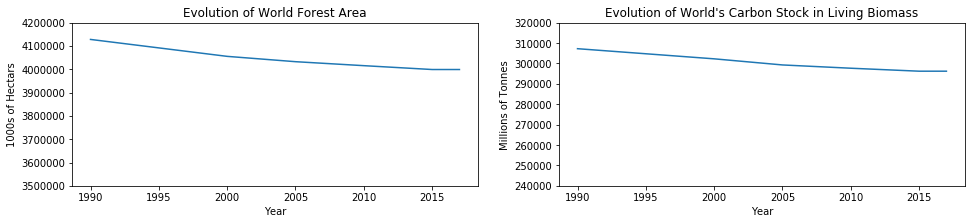

In [38]:
# Plot nominal and per capita CO2eq world agricultural emissions over time excluding new emissions
fig = plt.figure(figsize=(16,3))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.plot(world_forest_area.Year.values, world_forest_area.Value.values)
p2.plot(world_forest_cs.Year.values, world_forest_cs.Value.values)
p1.set_ylim([3500000,4200000])
p2.set_ylim([240000, 320000])
p1.set_xlabel('Year')
p1.set_ylabel('1000s of Hectars')
p1.set_title('Evolution of World Forest Area')
p2.set_xlabel('Year')
p2.set_ylabel('Millions of Tonnes')
p2.set_title("Evolution of World's Carbon Stock in Living Biomass")
plt.show()

From the above plots, we can observe that both the area represented by the world's forests and its ability to absorb carbon have decreased over time. It is important to observe the y-axis of both plots because although there is a decrease it is slight.

In [39]:
world_forest_decrease = ((world_forest_area[world_forest_area.Year==world_forest_area.Year.min()].Value.values \
                        - world_forest_area[world_forest_area.Year==world_forest_area.Year.max()].Value.values) \
                        / world_forest_area[world_forest_area.Year==world_forest_area.Year.min()].Value.values)[0]

In [40]:
world_carbonstock_decrease = ((world_forest_cs[world_forest_cs.Year==world_forest_cs.Year.min()].Value.values \
                            - world_forest_cs[world_forest_cs.Year==world_forest_cs.Year.max()].Value.values) \
                            / world_forest_cs[world_forest_cs.Year==world_forest_cs.Year.min()].Value.values)[0]

In [41]:
print('Decrease of world forest area as percentage of level in 1990: ', world_forest_decrease)
print('Decrease of world forest carbon stock in biomass as percentage of level in 1990: ', world_carbonstock_decrease)

Decrease of world forest area as percentage of level in 1990:  0.03128087022915876
Decrease of world forest carbon stock in biomass as percentage of level in 1990:  0.03591410250475208


We can see that both have decreased by slightly more than 3% since 1990. Although this number might seem low it is a noteable decrease for the observed time period. Additionally, it is worth observing that even though both share a similar decreasing trend, they have decreased slightly differently proportionally indicating that not all forest share the same carbon absorbing capabilities.

In [42]:
world_map = 'data/world_countries.json'
forest_map = folium.Map(location=[40, 15], zoom_start=2)
folium.Choropleth(
    geo_data=world_map,
    data=cspc_latest,
    columns=['ISO3 Code', 'Value'],
    key_on='feature.id',
    fill_color='YlGn', 
    fill_opacity=0.9, 
    line_opacity=0.2,
    nan_fill_color='grey',
    legend_name='Millions of tonnes in carbon stock in living biomass'
).add_to(forest_map)
forest_map

From the plot above we can observe the distribution of the carbon stock in living biomass across the various countries of the world. The carbon stock in living biomass in the context of forests refers to the amount of carbon stored in the world's forest ecosystem. The plot illustrates the fact that heavy reliance is placed on very few countries' forests. Predominantly, the Brazilian Amazon rainforest seems to plays a crucial role in absorbing the world's carbon. Additionally, Russia seems to be a key player as well, with Canada, the United-States, Indonesia and the Democratic Republic of Congo holding also holding a significant portion of the world's carbon stock. We investigate below how these few select countries' forests have evolved over time.

In [43]:
green_countries = ['Russian Federation', 'Brazil', 'Democratic Republic of the Congo', 
                   'United States of America', 'Canada', 'Indonesia']

In [44]:
# Extract forest area data for the chosen subset of countries starting in 1992 as Russia before then was the USSR
green_countries_forests = forest_per_country[(forest_per_country.Area.isin(green_countries)) 
                                             & (forest_per_country.Year>1991)].copy()

In [45]:
# Create dict with forest area in 1992 for select subset of countries
base_area = {k: v for (k,v) in green_countries_forests[green_countries_forests.Year==1992][['Area', 'Value']].values}

# Normalize the forest area levels for each country each year according to their respective baselines
green_countries_forests['Value_Norm'] = green_countries_forests.apply(lambda row: 100*row.Value/base_area.get(row.Area),
                                                                  axis=1)

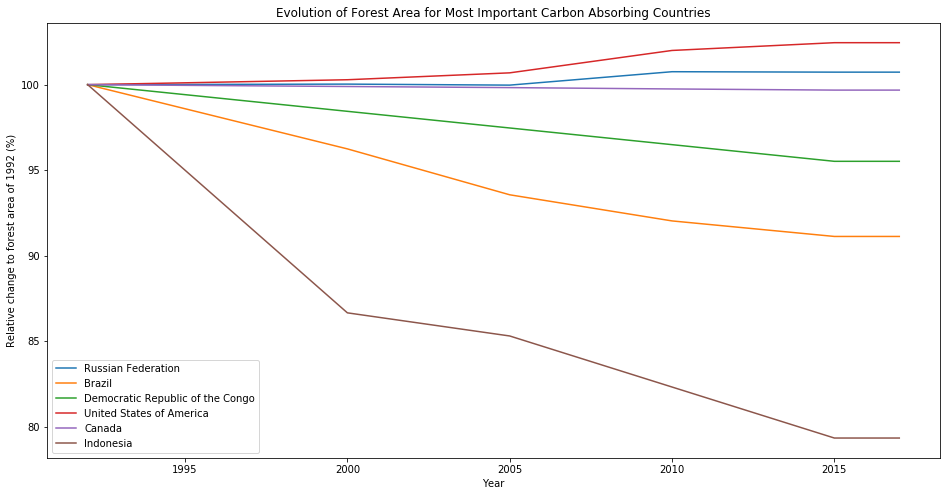

In [46]:
# Plot evolution of forest area for each country in chosen subset
plt.figure(figsize=(16,8))
for g in green_countries:
    plt.plot(green_countries_forests[green_countries_forests.Area==g].Year.values,
             green_countries_forests[green_countries_forests.Area==g].Value_Norm.values, label=g)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Relative change to forest area of 1992 (%)')
plt.title('Evolution of Forest Area for Most Important Carbon Absorbing Countries')
plt.show()

The plot above illustrates the change of forest areas for the chosen subset of countries with a baseline of 1992. We can observe that certain countries like Brazil, Indonesia and the Democratic Republic of Congo have reduced over this time period. On the other hand, Russia, Canada and the United States have managed to stay at the same level throughout this time period or even increase the forest area within their country. It is worth pointing out that as we have observed that Brazil holds the biggest proportion of the world's carbon stock, it is alarming to see that it is one of the countries with a steady downwards slope for their forest area over the last 20 years.

## ll. How are countries facing the problem of feeding a growing population
In this section we're interested in seeing how countries did scale their food production to face the problematic of the growing popoulation. We're further interested in discovering wheter the countries were able to increase their food production in a sustainable way i.e. by substantially reducing the `Emissions intensity` of the most commonly used food. In an attempt to do that, we used the `Emissions intensities` [dataset](http://www.fao.org/faostat/en/#data/EI) which contains relevant information regarding the amount of green gases produced by some common food such as meat, milk and rice.

In [47]:
emissions_df = pd.read_csv('data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip', encoding='latin-1')
emissions_df = emissions_df[emissions_df.Area != 'China']

In [48]:
world_emissions_intensity = emissions_df[(emissions_df.Element == 'Emissions intensity') & (emissions_df.Area == 'World')]
items = world_emissions_intensity.Item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk = list(filter(lambda x: 'Milk' in x, items))
remaining = list(set(items) - set(meat + milk))

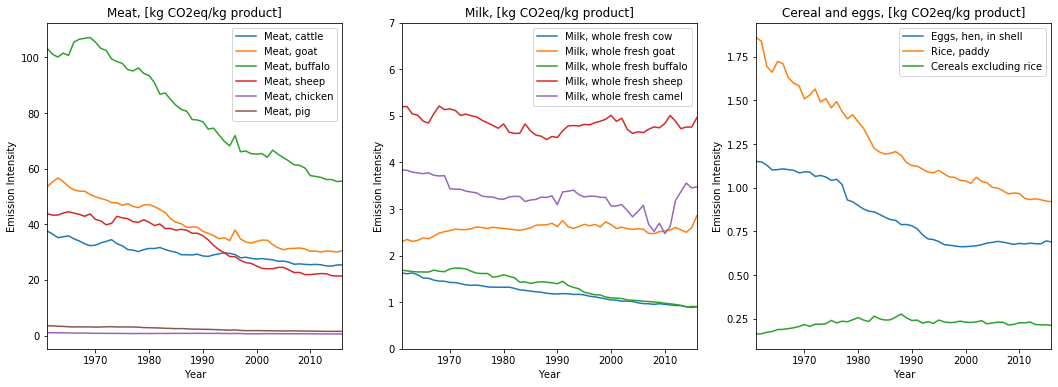

In [49]:
world_emissions_intensity = world_emissions_intensity[['Item', 'Year', 'Value']].groupby(['Item', 'Year'], as_index=False).agg('mean')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for item in meat:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[0], label=item)
    axes[0].legend()
    axes[0].set_ylabel('Emission Intensity')
    axes[0].set_title('Meat, [kg CO2eq/kg product]')
    
for item in milk:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[1], label=item)
    axes[1].legend()
    axes[1].set_ylabel('Emission Intensity')
    axes[1].set_title('Milk, [kg CO2eq/kg product]')
    axes[1].set_ylim([0,7])
    
for item in remaining:
    world_emissions_intensity[world_emissions_intensity.Item == item].plot(x='Year', y='Value', ax=axes[2], label=item)
    axes[2].legend()
    axes[2].set_ylabel('Emission Intensity')
    axes[2].set_title('Cereal and eggs, [kg CO2eq/kg product]')

From the above plots we observe a significantly decreasing trend in the `Emissions intensity`. Nonetheless, it does not contradicts the previously stated fact that the total amount of `Emissions (CO2eq)` of the agricultural sector is increasing for the following reasons:
 - The overall population could be increasing faster than the `Emissions intensity` is decreasing.
 - There could be a shift in the in the most consummed food towards food which have a higher `Emissions intensity`.

In [50]:
def food_type(food_item):
    if food_item in meat:
        return 'meat'
    elif food_item in milk:
        return 'milk'
    return 'rice or cereals'

In [51]:
# Cluster food with respect to either {'meat', 'milk', 'rice or cereals'}
emissions_df['food_type'] = emissions_df.Item.apply(lambda x: food_type(x))

In [52]:
def plot_emissions_food_type(year):
    """
    plots the emissions proportions by food type for a given year
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    world_net_production = emissions_df[(emissions_df.Element == 'Production') & (emissions_df.Area == 'World') 
                                             & (emissions_df.Year == year)]
    world_net_production[['food_type', 'Value']].groupby('food_type').agg('sum').plot.pie(y='Value', 
                                                    ax=axes[0], fontsize=13, autopct='%1.1f%%')
    axes[0].set_ylabel('')
    axes[0].legend('')
    axes[0].set_title('Total Food Production by Type ({})'.format(year), fontsize=16)


    world_net_emission_2016 = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.Area == 'World') 
                                             & (emissions_df.Year == year)]
    world_net_emission_2016[['food_type', 'Value']].groupby('food_type').agg('sum').plot.pie(y='Value', 
                                                    ax=axes[1], fontsize=13, autopct='%1.1f%%')
    axes[1].set_ylabel('')
    axes[1].legend('')
    axes[1].set_title('Contribution to Total CO2 Emissions by Type ({})'.format(year), fontsize=16)
    plt.show() 

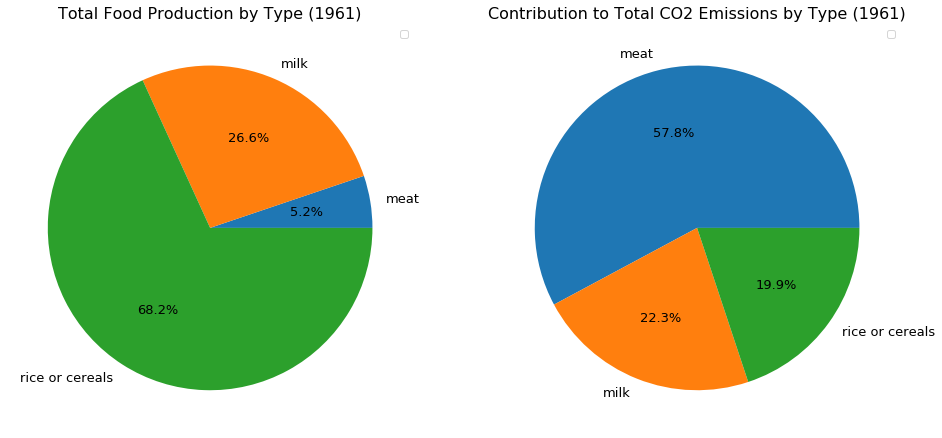

In [53]:
# Plotting the emissions by food type for the year 1961
plot_emissions_food_type(1961)

We observe that there is a great inbalance in the amount of `Emissions intensity` of different food types. For instance, `meat` which represents a very small proportion of the total amount of food produced is responsible for almost 60% of the total food related emissions.

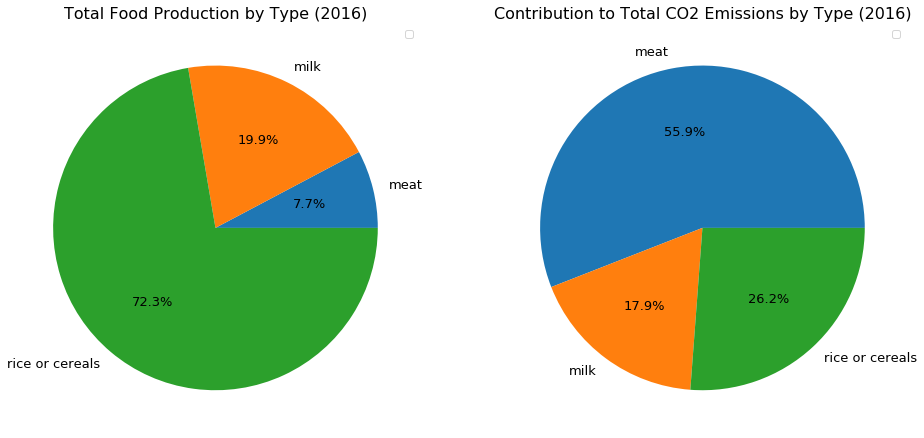

In [54]:
# Plotting the emissions by food type for the year 2016
plot_emissions_food_type(2016)

We observe a small shift in eating habits towards, nonetheless this is not reflected in the total emissions. This can be explained by the previously depicted improvement in the efficiency to produce meat.

In [55]:
food_balance_df = pd.read_csv('data/FoodBalanceSheets_E_All_Data_(Normalized).zip', encoding='latin-1')

In [56]:
food_balance_df[(food_balance_df.Item == 'Grand Total') ].Element.unique()

array(['Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

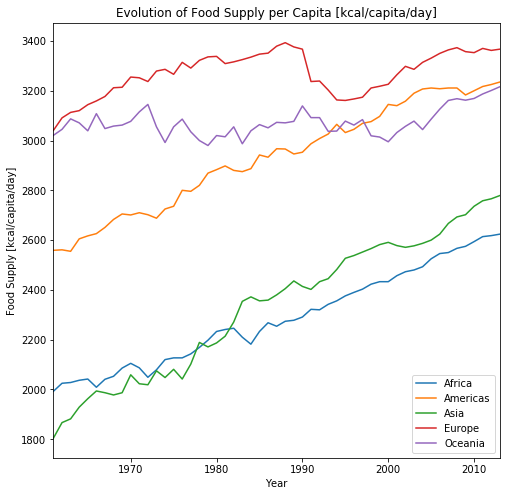

In [57]:
total_df = food_balance_df[(food_balance_df.Element == 'Food supply (kcal/capita/day)') & 
                (food_balance_df.Item == 'Grand Total')][['Area', 'Year', 'Value']]
fig, ax = plt.subplots(figsize=(8, 8))
for continent in continents:
    total_df[total_df.Area == continent].plot(ax=ax, x='Year', y='Value')
    ax.legend(continents)
    ax.set_title('Evolution of Food Supply per Capita [kcal/capita/day]')
    ax.set_ylabel('Food Supply [kcal/capita/day]')

Clearly we observe an increasing trend in the amount of food available which seems to indicate an overall increase food production efficiency. Nonetheless the above plot only depicts the produced food not necessarily the amount of food eaten.

## lll. Which countries contribute the most to the greenhouse effect by their agriculture
In this section we'll try to see which countries are the biggest productors in greenhouse gases. To achieve this goal we'll be using the `Emissions intensities` [dataset](http://www.fao.org/faostat/en/#data/EI) which contains inforamtion related to the amount of [carbon dioxide equivalent](https://en.wikipedia.org/wiki/Carbon_dioxide_equivalent), `Emissions (CO2eq)`, generated by an aliment for a given country and year. In the context of this task we'll focusing on the latest available year, which happen to be 2014 for this dataset. As a first order approach each country will be attributed the amount of `Emissions (CO2eq)` that was produced in its own agricultural sector. 

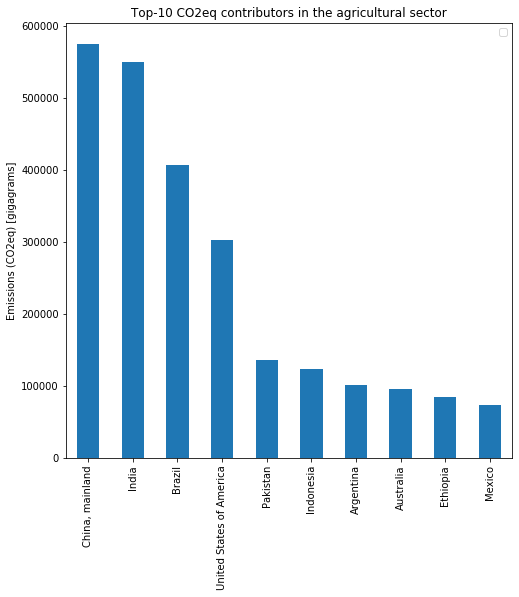

In [58]:
emissions_df['is_country'] = emissions_df['Area Code'].apply(lambda code: len(str(code)) < 4)
emissions_country = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.is_country)]
emissions_country_total = emissions_country[emissions_country.Year == 2014][['Area', 'Value']]\
    .groupby('Area', as_index=False).agg('sum').sort_values(by='Value', ascending=False)

# Plot the top-10 agricultural emissions producers
fig, ax = plt.subplots(figsize=(8, 8))
emissions_country_total.rename(columns={'Area': 'Country', 'Value': 'Emissions (CO2eq) [gigagrams]'})\
    .head(10).plot.bar(x='Country', y='Emissions (CO2eq) [gigagrams]', ax=ax)
ax.set_title('Top-10 CO2eq contributors in the agricultural sector')
ax.set_xlabel('')
ax.legend('')
ax.set_ylabel('Emissions (CO2eq) [gigagrams]')
plt.show()

The above plot is somehow coherent with our prior intuition. Nonetheless it also appears that the above countries are also the ones with the largest populations. This factor should be taken into account as it clearly is unfair towards big countries. As a more refined analysis we'll normalize the `Emissions (CO2eq)` by each country's population such as to get the `Emissions (CO2eq)/capita`.

In [59]:
# Selecting only countries
population_df['is_country'] = population_df['Area Code'].apply(lambda code: len(str(code)) < 4)
populations_2014 = population_df[(population_df.Element == 'Total Population - Both sexes') & (population_df.is_country)
                               & (population_df.Year == 2014) & (population_df.Area != 'China, mainland')]
populations_2014 = populations_2014[['Area', 'Value']].sort_values(by='Value', ascending=False)
populations_2014 = populations_2014.rename(columns={'Value': 'Population'})

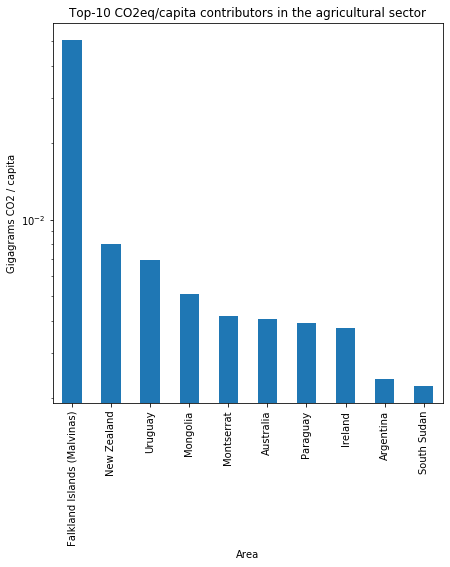

In [60]:
emissions_normalized = emissions_country_total.merge(populations_2014, how='inner')
emissions_normalized['Emissions (CO2eq)/capita'] = emissions_normalized.Value / (1000 * emissions_normalized.Population)

# Plot the top-10 agricultural normalized emissions producers
fig, ax = plt.subplots(figsize=(7, 7))
emissions_normalized.sort_values(by='Emissions (CO2eq)/capita', ascending=False)\
    .head(10).plot.bar(x='Area', y='Emissions (CO2eq)/capita', ax=ax, logy=True)
ax.set_title('Top-10 CO2eq/capita contributors in the agricultural sector')
ax.get_legend().remove()
ax.set_ylabel('Gigagrams CO2 / capita')
plt.show()

We observe a significant change in the top-10 represented countries as small countries/regions did not appear in the previous plot as their absolut `Emissions (CO2eq)`was not high enough. For the story, `Falkland Islands (Malvinas)` which may appear as an outlier can be explained as it is currently ranked $5^{th}$ in the worldwide GDP per capita and the fishing industry contributes towards 50-60% of its annual GDP ([Falkland Islands](https://en.m.wikipedia.org/wiki/Falkland_Islands)). It might seem artifical to give so much weight to countries whose total contribution is not absolutely high, nevertheless these countries also have the largest improvement margin, at least it appears so. In fact, this method is still intrinsically unfair as it doesn't take into account the amount of food that transits between countries. It is very likely that some of the food produced in ` Falkland Islands (Malvinas)` is then exported to other countries. A natural thing to do is to re-distribute the emissions related to exported food to where the latter will be consummed. To this end we used the `Detailed trade matrix` (dataset)[http://www.fao.org/faostat/en/#data/TM] which contains informations regarding the transfer of food inbetween countries. From the latter dataset only trades corresponding to food for which the emission intensity was available were treated.

The dataset `data/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip` contains a lot of very specific items like `Millet`, `Sorghumand` etc. Thefore, we will only consider overlapping items with the `emissions_df` dataframe. Since cereals are one of the most present items, we will agreggate them into a more general category `Cereals excluding rice` for which we have all the emissions information. Moreover, the column name `Rice - total  (Rice milled equivalent)` is changed into `Rice, paddy`. 1 unit of `Value` represents 1 tonne.


In [61]:
trade_matrix_df = pd.read_csv('data/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip', encoding='latin-1')

In [62]:
# From the FAOSTAT website
cereals = ['Barley',  'Maize',  'Millet',  'Oats', 'Rye', 'Sorghumand', 'Wheat']

def to_cereals(st):
    if st in cereals:
        return 'Cereals excluding rice'
    elif st == 'Rice - total  (Rice milled equivalent)':
        return 'Rice, paddy'
    return st

In [63]:
# Filter as described above
trade_matrix_df.loc[:, 'Item'] = trade_matrix_df.Item.apply(to_cereals)
trade_matrix_df = trade_matrix_df[trade_matrix_df.Item.isin(emissions_df.Item.unique())]
trade_matrix_df = trade_matrix_df[trade_matrix_df['Partner Countries']!='Unspecified Area']
trade_matrix_df = trade_matrix_df[trade_matrix_df['Reporter Countries']!='Unspecified Area']

In [64]:
# Remove useless columns
stripped_trade_matrix_df = trade_matrix_df[['Reporter Countries', 'Partner Countries', 'Value', 'Year', 'Item']]

In [65]:
# Export quantity per items
stripped_trade_matrix_df = trade_matrix_df[trade_matrix_df.Year==2014]
exports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Export Quantity']
exports_2014 = exports_2014[exports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Item', 'Value']]
exports_2014 = exports_2014.rename(columns={"Reporter Countries": "Exporter", "Partner Countries": "Importer"})
exports_2014 = exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [66]:
# Import quantity per items
imports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Import Quantity']
imports_2014 = imports_2014[imports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Item', 'Value']]
imports_2014 = imports_2014.rename(columns={"Reporter Countries": "Importer", "Partner Countries": "Exporter"})
imports_2014 = imports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [67]:
# All quantity per items
merged_exports_2014 = pd.concat([imports_2014, exports_2014])
merged_exports_2014 = merged_exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('max').reset_index()
merged_exports_2014 = merged_exports_2014.sort_values(['Value'], ascending=[False])
merged_exports_2014.head(10)

,Exporter,Importer,Item,Value
15766,United States of America,Japan,Cereals excluding rice,15743777.0
15839,United States of America,Mexico,Cereals excluding rice,13430447.0
15966,United States of America,Republic of Korea,Cereals excluding rice,6665503.0
2794,Canada,United States of America,Cereals excluding rice,6017434.0
11760,Russian Federation,Turkey,Cereals excluding rice,5687091.0
414,Australia,"China, mainland",Cereals excluding rice,5395524.0
15542,United States of America,Colombia,Cereals excluding rice,5065605.0
14341,Ukraine,Egypt,Cereals excluding rice,5050364.0
4656,France,Algeria,Cereals excluding rice,4884580.0
1973,Brazil,Iran (Islamic Republic of),Cereals excluding rice,4698583.0


In [68]:
# Select emissions only for 2014
emissions_intensities_2014_df = emissions_df[(emissions_df.Year == 2014) & (emissions_df.Element == 'Emissions intensity') 
                                        & (emissions_df.is_country)][['Area', 'Item', 'Value']]\
                                         .drop_duplicates().rename(columns={'Area': 'Exporter'})\
                                         .rename(columns={'Value': 'Emissions intensity'}).set_index(['Exporter', 'Item'])

In [69]:
import_export_df = merged_exports_2014.set_index(['Exporter', 'Item'])

In [70]:
emissions_import_export = import_export_df.merge(emissions_intensities_2014_df, how='inner', left_index=True, right_index=True) 
emissions_import_export['Emissions (CO2eq) [gigagrams]'] = emissions_import_export['Value'] *\
    emissions_import_export['Emissions intensity'] / 1000
emissions_import_export = emissions_import_export.reset_index()
emissions_export = emissions_import_export[['Exporter', 'Emissions (CO2eq) [gigagrams]']] \
    .groupby('Exporter').agg('sum').rename(columns={'Emissions (CO2eq) [gigagrams]': 'Out Emissions (CO2eq) [gigagrams]'})
emissions_import = emissions_import_export[['Importer', 'Emissions (CO2eq) [gigagrams]']]\
    .groupby('Importer').agg('sum').rename(columns={'Emissions (CO2eq) [gigagrams]': 'In Emissions (CO2eq) [gigagrams]'})

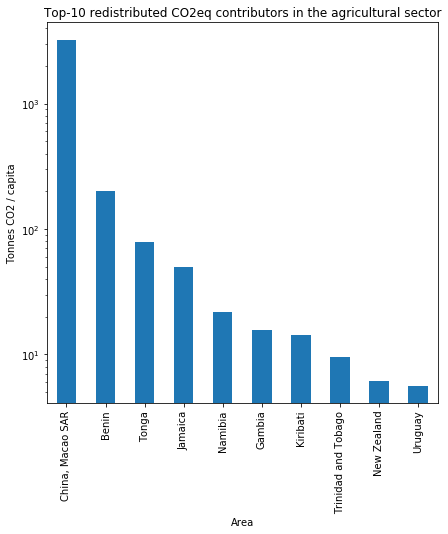

In [71]:
emissions_country_io = emissions_country_total.merge(emissions_export, how='left', left_on='Area', right_on='Exporter')
emissions_country_io = emissions_country_io.merge(emissions_import, how='left', left_on='Area', right_on='Importer')
emissions_country_io.fillna(value=0.0, inplace=True)
emissions_country_io['Normalized Emissions [gigagrams]'] = emissions_country_io['Value'] - \
    emissions_country_io['Out Emissions (CO2eq) [gigagrams]'] + emissions_country_io['In Emissions (CO2eq) [gigagrams]']
emissions_country_io = emissions_country_io.merge(populations_2014, how='inner')
emissions_country_io['Normalized Emissions [Tonnes/capita]'] = emissions_country_io['Normalized Emissions [gigagrams]'] /\
    emissions_country_io['Population']
fig, ax = plt.subplots(figsize=(7, 7))

# Plotting
emissions_country_io.sort_values(by='Normalized Emissions [Tonnes/capita]', ascending=False)\
    .head(10).plot.bar(x='Area', y='Normalized Emissions [Tonnes/capita]', ax=ax, logy=True)
ax.get_legend().remove()
ax.set_ylabel('Tonnes CO2 / capita')
ax.set_title('Top-10 redistributed CO2eq contributors in the agricultural sector')
plt.show()

## lV. Who feeds who ?

### Analysis

Once again, we look at the `data/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip` dataset. This, we proceed by aggregating on `Value`. That way, we will be able to plot the total transfer of money (w.r.t. food) bewteen all countries that trade together. 1 unit of `Value` represents 1000 dollars.

We will also merge the `data/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip` dataset with the `country_metadata` dataframe. As such we will be able to cluster manually countries which are part of the same continent and see if the trading between countries acutally reflect the geographical location. We expect it would since it reduces the transport costs.

In [93]:
# Add geographical grouping for plotting
countries = country_metadata.Country.drop_duplicates().values
continents = country_metadata[(country_metadata['Country Group Code']>5000) & (country_metadata['Country Group Code']%100==0)]
continents = continents['Country Group'].drop_duplicates().values
mapping = country_metadata[country_metadata['Country Group'].isin(continents)].sort_values('Country Code')[['Country Group', 'Country']]

In [94]:
# Exports by total value
exports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Export Value']
exports_2014 = exports_2014[exports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Value', 'Item']]
exports_2014 = exports_2014.rename(columns={"Reporter Countries": "Exporter", "Partner Countries": "Importer"})
exports_2014 = exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [95]:
# Imports by total value
imports_2014 = stripped_trade_matrix_df[stripped_trade_matrix_df['Element']=='Import Value']
imports_2014 = imports_2014[imports_2014.Value > 0.0][['Reporter Countries', 'Partner Countries', 'Value', 'Item']]
imports_2014 = imports_2014.rename(columns={"Reporter Countries": "Importer", "Partner Countries": "Exporter"})
imports_2014 = imports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('sum').reset_index()

In [96]:
# All total value
merged_exports_2014 = pd.concat([imports_2014, exports_2014])
merged_exports_2014 = merged_exports_2014.groupby(['Exporter', 'Importer', 'Item']).agg('max').reset_index()
merged_exports_2014 = merged_exports_2014.merge(mapping, left_on='Exporter', right_on='Country', how='inner').rename(columns={'Country Group': "Exporter Continent"}).drop(columns='Country')
merged_exports_2014 = merged_exports_2014.merge(mapping, left_on='Importer', right_on='Country', how='inner').rename(columns={'Country Group': "Importer Continent"}).drop(columns='Country')
merged_exports_2014 = merged_exports_2014.sort_values(['Value'], ascending=[False]).reset_index(drop=True)
merged_exports_2014 = merged_exports_2014.iloc[:600] # reduce edges number

# Reduce number of edges for graph
value_graph_edges_2014 = merged_exports_2014.groupby(['Exporter', 'Importer', 'Exporter Continent', 'Importer Continent'], as_index=False).agg('sum')
value_graph_edges_2014 = value_graph_edges_2014.sort_values('Value', ascending=False)
value_graph_edges_2014 = value_graph_edges_2014.iloc[:100]
value_graph_edges_2014.head(10)

,Exporter,Importer,Exporter Continent,Importer Continent,Value
440,United States of America,Mexico,Americas,Americas,5562729.0
436,United States of America,Japan,Americas,Asia,4565252.0
446,United States of America,Republic of Korea,Americas,Asia,2317621.0
121,Canada,United States of America,Americas,Americas,2278570.0
23,Australia,"China, mainland",Oceania,Asia,2133094.0
244,Netherlands,Germany,Europe,Europe,1777656.0
150,France,Italy,Europe,Europe,1696686.0
172,Germany,Netherlands,Europe,Europe,1656237.0
170,Germany,Italy,Europe,Europe,1457045.0
141,France,Algeria,Europe,Africa,1452775.0


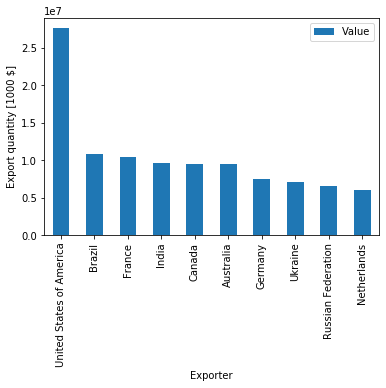

In [127]:
# Top exports
tmp = merged_exports_2014.groupby(['Exporter']).agg('sum').reset_index(drop=False).sort_values('Value', ascending=False).iloc[:10]
tmp.plot.bar(x='Exporter', y='Value')
plt.ylabel('Export quantity [1000 $]')
plt.show()

# JSON output
lst = []
for index, row in tmp.iterrows():
    lst.append({'key': row.Exporter, 'value': row.Value})
    
with open('datastory/public/top_exporters.json', 'w') as fp:
    json.dump(lst, fp)

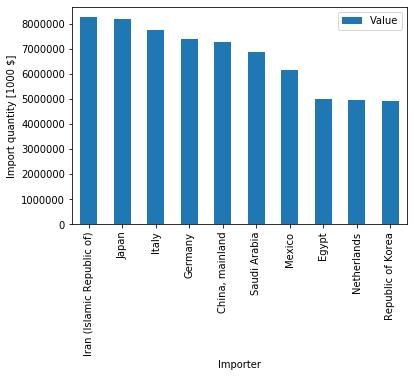

AttributeError: 'Series' object has no attribute 'Exporter'

In [129]:
# Top imports
tmp = merged_exports_2014.groupby(['Importer']).agg('sum').reset_index(drop=False).sort_values('Value', ascending=False).iloc[:10]
tmp.plot.bar(x='Importer', y='Value')
plt.ylabel('Import quantity [1000 $]')
plt.show()

# JSON output
lst = []
for index, row in tmp.iterrows():
    lst.append({'key': row.Exporter, 'value': row.Value})
    
with open('datastory/public/top_importers.json', 'w') as fp:
    json.dump(lst, fp)

In [97]:
# JSON export
countries = pd.concat([merged_exports_2014['Exporter'], merged_exports_2014['Importer']]).to_frame().drop_duplicates().sort_values(0)
countries.columns = ['name']
countries['id'] = countries['name'].rank().astype(int) + 5
continents = merged_exports_2014['Exporter Continent'].drop_duplicates().to_frame()
continents.columns = ['name']
continents['id'] = continents['name'].rank().astype(int)

# Retain id's
tmp = countries.merge(mapping, left_on='name', right_on='Country', how='inner')
tmp = tmp.merge(continents, left_on='Country Group', right_on='name', how='inner').drop(columns=['Country', 'Country Group', 'name_y'])
tmp.columns = ['name', 'id', 'parent']
continents['parent'] = 0
continents = continents.append({'name': '__ROOT__', 'id': 0, 'parent': None}, ignore_index=True)
nodes = pd.concat([continents, tmp])
nodes = nodes.sort_values('id').reset_index(drop=True)

In [77]:
# Global dict to save to file
D3_exports_data = dict()
D3_exports_data['countries'] = nodes.to_dict('record')

In [78]:
import json

# Export trades
trades = merged_exports_2014.groupby(['Exporter', 'Importer', 'Exporter Continent', 'Importer Continent'], as_index=False).agg('sum').drop(columns=['Exporter Continent', 'Importer Continent']).sort_values('Value', ascending=False)
trades = trades.merge(nodes, left_on='Exporter', right_on='name', how='inner').drop(columns=['parent', 'name', 'Exporter'])
trades = trades.merge(nodes, left_on='Importer', right_on='name', how='inner').drop(columns=['parent', 'name', 'Importer'])
trades = trades.sort_values('Value', ascending=False).reset_index(drop=True)
trades['Value'] = trades['Value'].astype(int)
D3_exports_data['trades'] = trades.values.tolist()

In [79]:
# Top 3 exports
top3_exports = merged_exports_2014.groupby(['Exporter', 'Item'], as_index=False).agg('sum')
top3_exports['rank_item'] = top3_exports.groupby('Exporter')['Value'].rank(ascending=False)
top3_exports = top3_exports.sort_values(['Exporter', 'rank_item'])
top3_exports = top3_exports[top3_exports.rank_item <= 3.5]

# Top 3 exports
top3_imports = merged_exports_2014.groupby(['Importer', 'Item'], as_index=False).agg('sum')
top3_imports['rank_item'] = top3_imports.groupby('Importer')['Value'].rank(ascending=False)
top3_imports = top3_imports.sort_values(['Importer', 'rank_item'])
top3_imports = top3_imports[top3_imports.rank_item <= 3.5]

In [80]:
def custom_to_dict(top3_exports, st):
    '''
    Returns a dict of the dataframe in a custom format for using in D3
    '''
    top3_exports_item = top3_exports.groupby(st)['Item'].apply(list)
    top3_exports_value = top3_exports.groupby(st)['Value'].apply(list)
    exports_dict = dict()
    for key in top3_exports_item.to_dict().keys():
        lst = []
        for i in range(len(top3_exports_item[key])):
            obj = dict()
            obj['name'] = top3_exports_item[key][i]
            obj['value'] = top3_exports_value[key][i]
            lst.append(obj)
        exports_dict[key] = lst
    return exports_dict

In [81]:
# Add resulting custom dict to final output
best_imports = custom_to_dict(top3_imports, 'Importer')
best_exports = custom_to_dict(top3_exports, 'Exporter')
for item in D3_exports_data['countries']:
    country = item['name']
    if country in best_exports:
        item['top_exports'] = best_exports[country]
    else:
        item['top_exports'] = []
    
    if country in best_imports:
        item['top_imports'] = best_imports[country]
    else:
        item['top_imports'] = []

In [82]:
len(D3_exports_data['countries'])

128

In [83]:
long_to_short_names = dict()
long_to_short_names['Bolivia (Plurinational State of)'] = 'Bolivia'
long_to_short_names['Bosnia and Herzegovina'] = 'Bosnia'
long_to_short_names['Brunei Darussalam'] = 'Brunei'
long_to_short_names['China, Hong Kong SAR'] = 'Hong Kong'
long_to_short_names['China, Macao SAR'] = 'Macao'

long_to_short_names['China, Taiwan Province of'] = 'Taiwan'
long_to_short_names['China, mainland'] = 'China'
long_to_short_names['Democratic People\'s Republic of Korea'] = 'North Korea'
long_to_short_names['Democratic Republic of the Congo'] = 'DRC'
long_to_short_names['Iran (Islamic Republic of)'] = 'Iran'
long_to_short_names['Lao People\'s Democratic Republic'] = 'Laos'
long_to_short_names['Republic of Korea'] = 'South Korea'
long_to_short_names['Republic of Moldova'] = 'Moldova'

long_to_short_names['Russian Federation'] = 'Russia'
long_to_short_names['Syrian Arab Republic'] = 'Syria'
long_to_short_names['United Arab Emirates'] = 'UAE'
long_to_short_names['United Republic of Tanzania'] = 'Tanzania'
long_to_short_names['United States of America'] = 'USA'
long_to_short_names['Venezuela (Bolivarian Republic of)'] = 'Venezuela'

long_to_short_names['Dominican Republic'] = 'Dominican Rep'
long_to_short_names['Trinidad and Tobago'] = 'Trinidad Tobago'
long_to_short_names['Papua New Guinea'] = 'New Guinea'

# Shorten country name
for item in D3_exports_data['countries']:
    country = item['name']
    if country in long_to_short_names:
        item['name'] = long_to_short_names[country]
        
# Write to file
with open('D3/trade_data.json', 'w') as fp:
    json.dump(D3_exports_data, fp)

In [84]:
D3_exports_data['countries']

[{'name': '__ROOT__',
  'id': 0,
  'parent': None,
  'top_exports': [],
  'top_imports': []},
 {'name': 'Africa',
  'id': 1,
  'parent': 0,
  'top_exports': [],
  'top_imports': []},
 {'name': 'Americas',
  'id': 2,
  'parent': 0,
  'top_exports': [],
  'top_imports': []},
 {'name': 'Asia', 'id': 3, 'parent': 0, 'top_exports': [], 'top_imports': []},
 {'name': 'Europe',
  'id': 4,
  'parent': 0,
  'top_exports': [],
  'top_imports': []},
 {'name': 'Oceania',
  'id': 5,
  'parent': 0,
  'top_exports': [],
  'top_imports': []},
 {'name': 'Afghanistan',
  'id': 6,
  'parent': 3,
  'top_exports': [],
  'top_imports': [{'name': 'Rice, paddy', 'value': 100438.0}]},
 {'name': 'Algeria',
  'id': 7,
  'parent': 1,
  'top_exports': [],
  'top_imports': [{'name': 'Cereals excluding rice', 'value': 3349392.0}]},
 {'name': 'Angola',
  'id': 8,
  'parent': 1,
  'top_exports': [],
  'top_imports': [{'name': 'Meat, chicken', 'value': 404101.0},
   {'name': 'Rice, paddy', 'value': 167152.0}]},
 {'name'

In [85]:
exports_to_dict = dict()
for item in D3_exports_data['countries']:
    country_id = item['id']
    exports_to = set()
#     imports_from = set()
    for trade in D3_exports_data['trades']:
        if trade[1] == country_id:
            exports_to.add(trade[2])
    exports_to.add(country_id)
    exports_to_dict[country_id] = list(exports_to)

D3_exports_data['exports_to'] = exports_to_dict

In [86]:
# Write to file
with open('datastory/public/trade_data.json', 'w') as fp:
    json.dump(D3_exports_data, fp)

In [87]:
D3_exports_data['exports_to']

{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [7,
  9,
  21,
  25,
  29,
  31,
  37,
  53,
  55,
  61,
  73,
  75,
  89,
  94,
  97,
  115,
  118,
  121,
  124,
  125,
  126],
 10: [10],
 11: [11,
  14,
  24,
  27,
  28,
  37,
  53,
  54,
  55,
  60,
  61,
  64,
  73,
  77,
  80,
  82,
  84,
  87,
  90,
  93,
  94,
  97,
  107,
  112,
  118,
  119,
  120,
  121,
  125,
  126],
 12: [58, 43, 12],
 13: [13],
 14: [14],
 15: [15],
 16: [96, 16],
 17: [41, 43, 79, 17, 119, 58, 91],
 18: [18],
 19: [19],
 20: [20],
 21: [7,
  8,
  21,
  26,
  27,
  28,
  37,
  53,
  54,
  55,
  60,
  61,
  64,
  70,
  73,
  75,
  79,
  84,
  93,
  94,
  96,
  97,
  100,
  104,
  118,
  124,
  125,
  126],
 22: [70, 105, 45, 110, 22, 58, 94, 95],
 23: [23],
 24: [7,
  15,
  17,
  21,
  24,
  25,
  26,
  28,
  29,
  31,
  36,
  44,
  53,
  55,
  58,
  60,
  74,
  75,
  79,
  82,
  89,
  92,
  94,
  97,
  105,
  106,
  107,
  115,
  118,
  119,
  121,
  124],
 25: [121, 2

### Visualization

In this section, we will try different methods to answer the research question of who feeds who. Nothing is as strong as a good visualization here since answering this question corresponds to analysing graphs with high dimensionality. In this graph, vertices correspond to countries and edges correspond to the export value and import value between 2 countries. As such, it is a multigraph (with at most 2 edges between vertices) and not a graph in the normal with only one edge between vertices.

To avoid overcrowding of the plot, we remove trading edges which have a low value and don't have a significant impact.

In [88]:
import networkx as nx

# Make graph
G = nx.from_pandas_edgelist(value_graph_edges_2014, 'Exporter', 'Importer', ['Value'], 
                                  create_using=nx.MultiDiGraph())

# Coloring scale
colors = np.array(value_graph_edges_2014.Value)
colors = colors
colors = (colors - colors.min()) / (colors.max() - colors.min())

/home/tim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/tim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/tim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/tim/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  

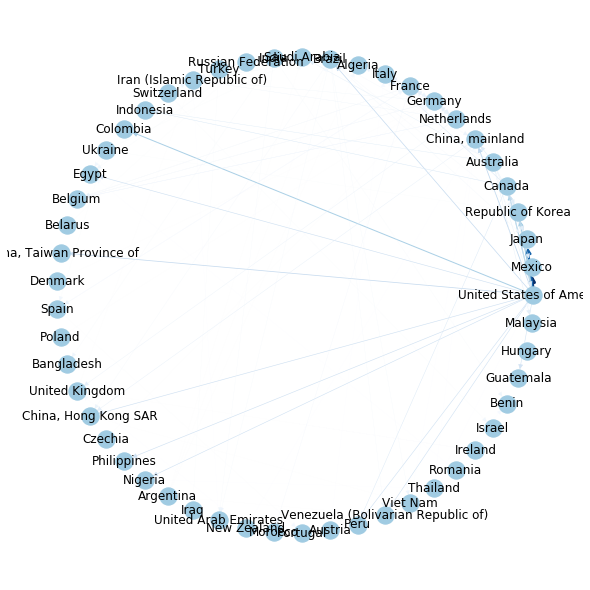

In [89]:
import matplotlib.pyplot as plt

# First attempt at visualisation
plt.figure(figsize=(8, 8))
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors,
        width=3*colors, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

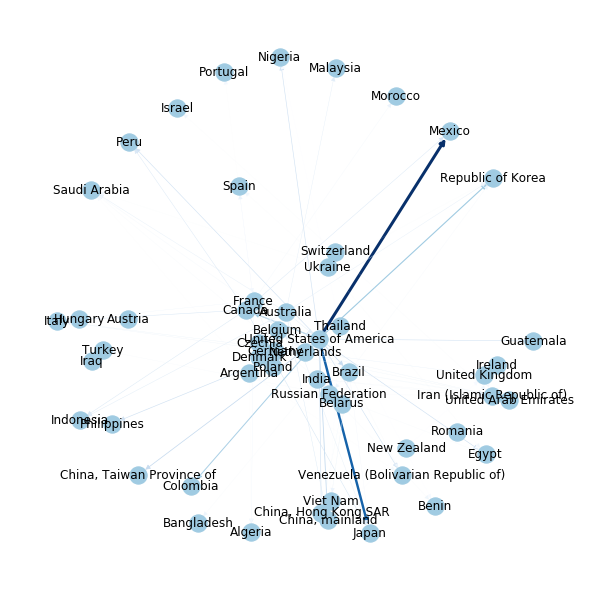

In [90]:
# Different layout
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors,
        width=3*colors, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

The edges in the 2 above plots represent the flow of money (w.r.t. food) between countries. It is beautiful to see that there is a geographical clustering. European countries mostly trade together and the US trades with a lot of other countries (see below for better plot).

One flaw of drawing is that it does not support bidirectional edges since the edges are drawn straight. The plot below solves this.

In [91]:
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image

# Other type of graph
G.graph['edge'] = {'arrowsize': '1', 'splines': 'curved'}
A = to_agraph(G)
A.graph_attr.update(ranksep='1', rankdir="LR")
lay = 'dot'
A.layout(lay)
A.draw('figures/export_import_graph.png')
Image(filename='figures/export_import_graph.png')

/home/tim/anaconda3/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Error: node United States of America, position 439.72,967, expected two doubles
Error: node Mexico, position 1034.8,1288, expected two doubles
Error: node Japan, position 1034.8,1166, expected two doubles
Error: node Republic of Korea, position 1034.8,744, expected two doubles
Error: node Canada, position 719.06,1310, expected two doubles
Error: node China, mainland, position 1034.8,1013, expected two doubles
Error: node Brazil, position 719.06,552, expected two doubles
Error: node Colombia, position 719.06,844, expected two doubles
Error: node Egypt, position 1347.3,748, expected two doubles
Error: node China, Taiwan Province of, position 719.06,790, expected two doubles
Error: node China, Hong Kong SAR, position 1347.3,967, expected two doubles
Error: node Philippines, position 719.06,736, expected two doubles
Error: node Nigeria, position 719.06,384, expected two doubles
Error: node Peru, posi

Below, you can find a preview of the interactive D3 plot. **Have a look at the [html file](/files/D3/diagram.html) for the interactive experience. If you don't run the notebook, just open the only html file in the D3 folder**. This plot shows how countries trade together. The shades of blue (when hovering over a country) indicate how much that particular country exports to other countries. We will also add a pop-up such that when you hover over a country, you see the top 3 imported / exported item (e.g. cereals, meat, ...) as well as quantitative metrics to better interpret it. We will also add a way to show the different continents.

Once again, you can clearly see a geographical clustering of countries when looking at the quantity of edges between 2 countries. The number of edges between countries in the same continent is much higher.

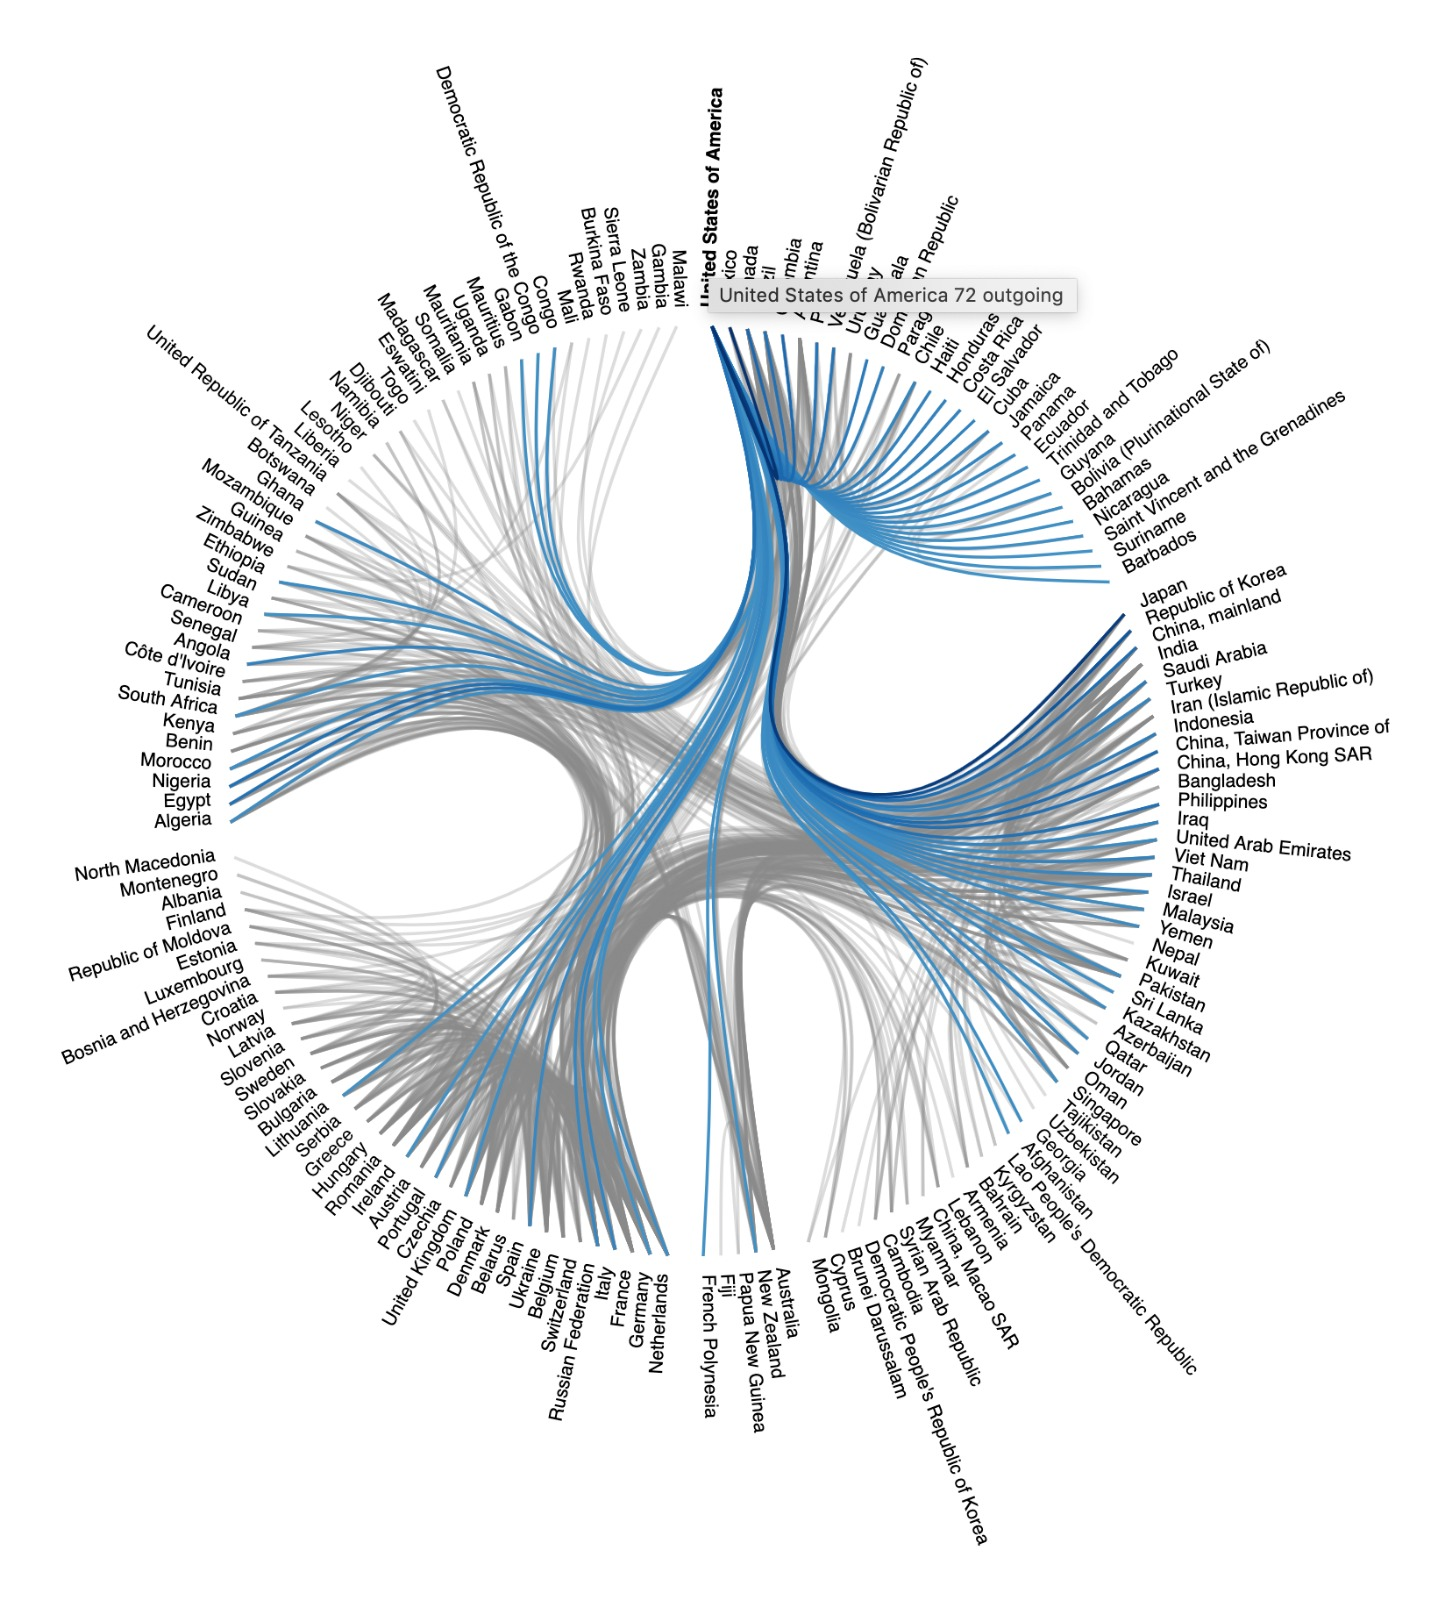

In [92]:
Image(filename='D3/export_import_test.jpeg')